# SSD: Single Shot MultiBox Detector 
### Object Detection
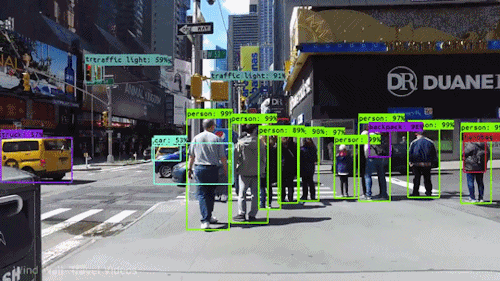

 SSD, the full name of Single Shot MultiBox Detector, is a target detection algorithm proposed by Wei Liu at ECCV 2016. As of now, it is one of the main detection frameworks. Compared with Faster RCNN, it has a clear speed advantage, and it has YOLO Obvious mAP advantage (but has been surpassed by CVPR 2017's YOLO9000). SSD has the following main features:
 
1. Inherited the idea of ​​converting detection to regression from YOLO, and completed network training at one time
2. Based on anchor in Faster RCNN, a similar priority box is proposed.
3. Adding a detection method based on the Pyramidal Feature Hierarchy, which is equivalent to half a FPN idea
 
### Source of the SSD paper :
https://arxiv.org/pdf/1512.02325.pdf
 

 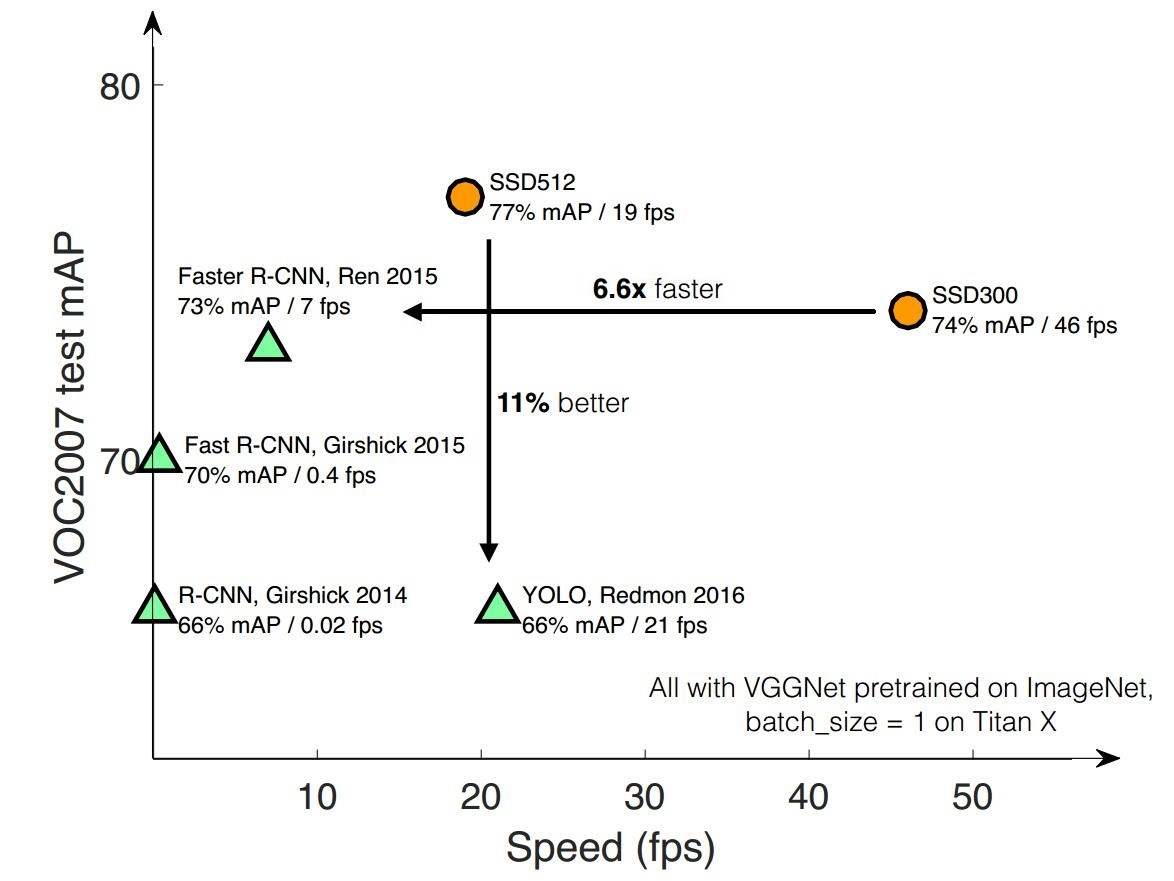
 
The SSD algorithm proposed in this paper is a multi-target detection algorithm that directly predicts the target category and bounding box . Compared with faster rcnn, this algorithm does not generate a proposal process, which greatly improves the detection speed. For different sizes of target detection, the traditional approach is to first convert the images into different sizes (image pyramids), then detect them separately, and finally combine the results. 

The SSD algorithm uses feature maps of  different convolutional layers  to achieve the same effect. The main network structure of the algorithm is VGG16. The last two fully connected layers are changed to convolutional layers, and then four convolutional layers are added to construct the network structure.


Wherein the output of the convolution of 5 different layers (feature map) each with two different 3 × 3 convolution kernel for convolution output a classification of confidence , each default box  generates confidence categories 21; a Output localization for regression, each default box generates 4 coordinate values (x, y, w, h). In addition, these five feature maps also generate a priority box (the coordinates are generated) through the PriorBox layer. The number of default boxes for each layer in the above five feature maps is given (8732). Finally, the first three calculation results are combined and passed to the loss layer.


### SSD network structure


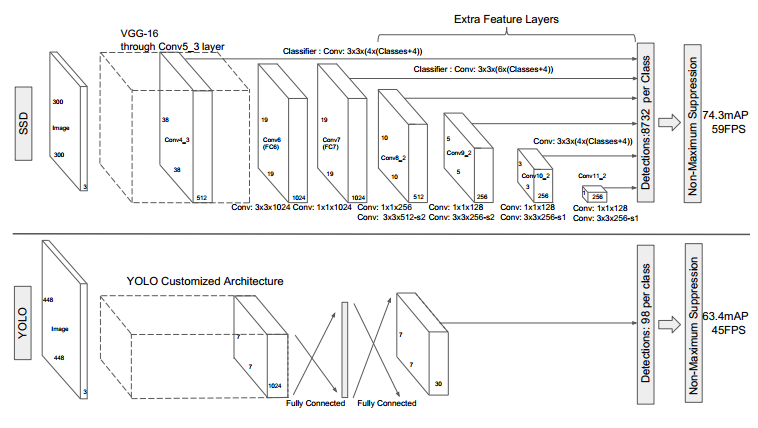

Figure 2 above shows the structure of the SSD 300 network in the original paper. It can be seen that YOLO is followed by a fully connected layer after the convolution layer, that is, only the highest-level feature maps (including Faster RCNN) are used for detection; and the SSD uses the feature pyramid structure for detection, that is, conv4-3 is used for detection. , Feature maps with different sizes, conv-7 (FC7), conv6-2, conv7-2, conv8_2, conv9_2, perform softmax classification and position regression on multiple feature maps at the same time, as shown in Figure 3.

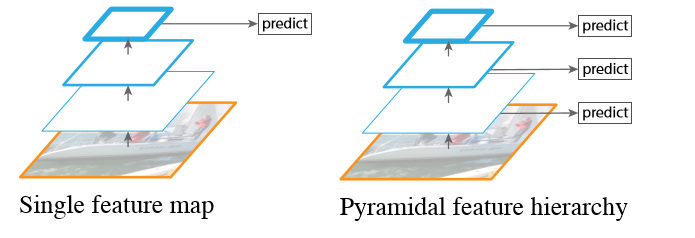

### Prior Box

The indentation introduces the Prior Box in the SSD. In fact, it is very similar to the anchor. It is a pre-selection box for some targets, and then the position of the real target is obtained through softmax classification + bounding box regression. The SSD generates a priority box according to the following rules:

Take the midpoint of each point on the feature map as the center (offset = 0.5), generate a series of concentric priority boxes (then the coordinates of the center point will be multiplied by step, which is equivalent to mapping from the feature map position back to the original map position)

The minimum side length of a square priority box is min_size and the maximum side length is: $\sqrt{minsize * maxsize}$

For each aspect ratio set in prototxt , 2 rectangles will be generated, the length and width are: $\sqrt{aspectratio * minsize}$  and  1/ $\sqrt{apectratio * minsize}$


The min_size and max_size of each feature map corresponding to the priority box are determined by the following formula, where m is the number of feature maps used (m = 6 in SSD 300):

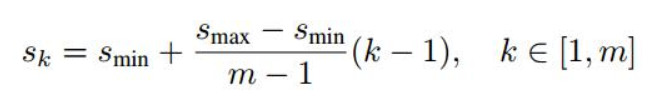


The min_size = S1 and max_size = S2 corresponding to the feature map in the first layer ; the min_size = S2 and max_size = S3 in the second layer ; and so on. In the original text, Smin = 0.2 and Smax = 0.9, but the priority box setting in SSD 300 does not correspond to the above formula in paper:


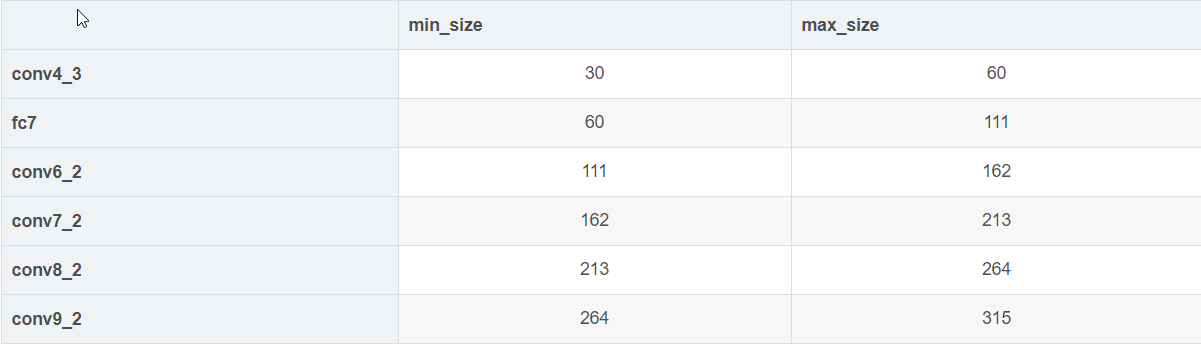

However, it can still be seen that SSD uses low-level feature maps to detect small targets and high-level feature maps to detect large targets, which should also be an outstanding contribution of SSDs. Among them, the conv4_3_norm_priorbox layer prototxt of the priority box generated by SSD 300.

Knowing how the priority box is generated, let's analyze how the priority box is used. Here take conv4_3 as an example for analysis.

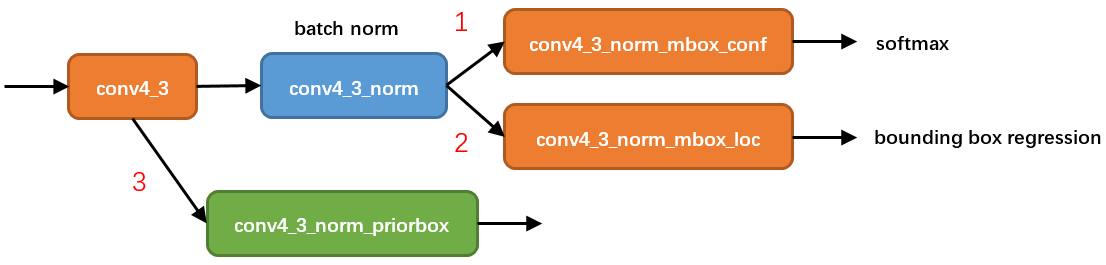

As can be seen from Figure 5, the conv4_3 feature map network pipeline is divided into 3 lines:

* After a batch norm + a convolution, [1, num_class * num_priorbox, layer_height, layer_width] features are generated for softmax classification of targets and non-targets (where num_class is the target class, and num_class = 21 in SSD 300)
* After a batch norm + convolution, a [1, 4 * num_priorbox, layer_height, layer_width] size feature is generated for bounding box regression (that is, a set of [d xmin , d ymin , d xmax , d ymax ] for each point ]

* A [1, 2, 4 * num_priorbox] size priority box blob is generated , where 2 channels respectively store the 4 point coordinates of the priority box and the corresponding 4 variances
The indentation can be predicted from the priox box by softmax classification + bounding box regression. Readers familiar with Faster RCNN should be familiar with the above process. In fact, the pribox box is very similar to the anchor in Faster RCNN. It is a preset box for the target, and there is no essential difference. The difference is that the priority boxes at each position are generally 4-6, less than the default 9 anchors of Faster RCNN; at the same time, the priority boxes are set on feature maps of different scales, and the sizes are different.


### Permute, Flatten And Concat Layers


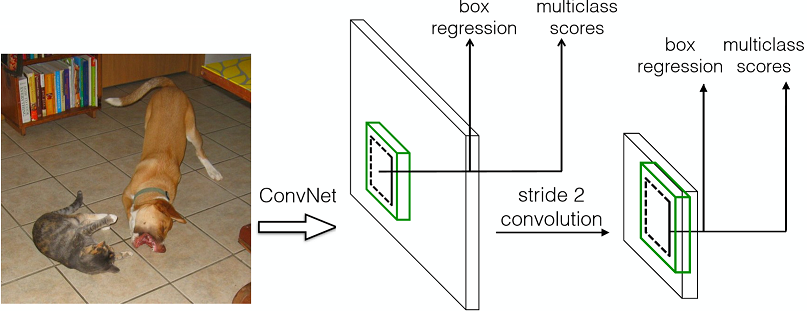

In the previous section used conv4_3 feature map to analyze how to detect the true position of the target, but SSD 300 uses a total of 6 feature maps including conv4_3 to detect the final target together. When the network is running, it can't obviously look like Figure 6: a feature map calculates softmax socre + box regression separately (although the principle is the same, but it cannot be achieved).


Permute is the layer that comes with SSD. The definition of conv4_3_norm_mbox_conf_perm above. Permute is equivalent to exchanging the data dimension in the caffe blob. The order of caffe blobs under normal circumstances is:

`bottom blob = [batch_num, channel, height, width]`

The caffe blob after conv4_3_norm_mbox_conf_perm is:

top blob = [batch_num, height, width, channel]



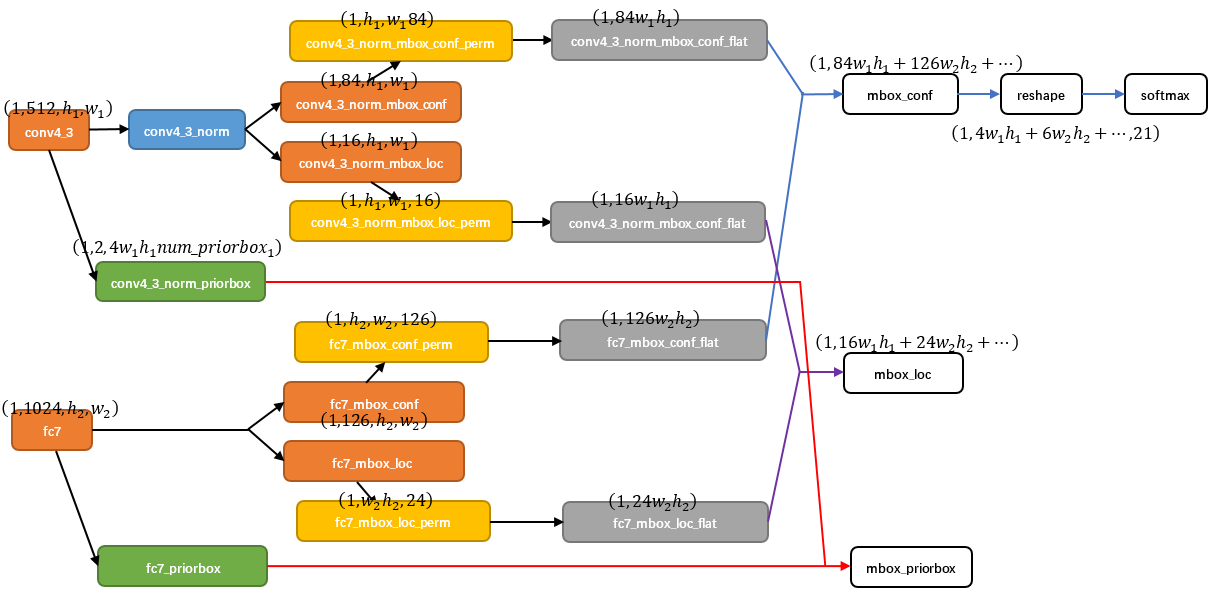

Then use conv4_3 and fc7 as examples to analyze how the SSD combines feature maps of different sizes for prediction. Figure 7 shows the changes in the caffe blob shape during the process of conv4_3 and fc7 merging (the other layers are similar, considering that the picture size is not drawn, please brain supplement).

* For the conv4_3 feature map, conv4_3_norm_priorbox (priorbox layer) sets a total of 4 priority boxes for each point. Since SSD 300 has 21 categories in total, the channel value of conv4_3_norm_mbox_conf is num_priorbox * num_class = 4 * 21 = 84; and each priority box must return 4 position transformations, so the caffe blob channel value of conv4_3_norm_mbox_loc is 4 * 4 = 16.
* fc7 has 6 priority boxes for each point, and other feature maps are the same.
* After a series of changes in the caffe blob shape shown in Figure 7, it is finally stitched into mbox_conf and mbox_loc. Mbox_conf is followed by reshape and then softmax (why reshape is performed before softmax, Faster RCNN mentioned).
* Finally these values are output detection_out_layer to get the detection result

### Hard negative mining

In general, the number of negative default boxes is much larger than the number of positive default boxes. If randomly selected samples are trained, the network will place too much emphasis on negative samples, and the loss will be unstable. Therefore, it is necessary to balance the samples: sort the default box according to the confidence score, select the box with a high confidence score for training, and control positive: negative = 1: 3


### Data augmentation

In order to make the model more robust to the different sizes and shapes of the input target, one needs to randomly sample the training image using one of the following methods:

* Use the original input image;
* Sample the original input image (sample a patch) so that the minimum value between the original input image and the target IoU is 0.1, 0.3, 0.5, 0.7, or 0.9;
* Randomly sample the original input image.


The size of the sampled image is the original image size [ 0 . . 1 ,1 ] , the aspect ratio range is [ 1 / 2 ,2 ] .

If the center of the real bounding box is in the sampled image, keep the overlapped part of the ground truth box if the center of it is in the sampled patch. Resampled image to fixed size (resized to fixed size), with probability 0. . . 5 randomly flipped horizontally, and applies the photometric distortion (applying some photo-metric distortions).

### Atrous Convolution explained


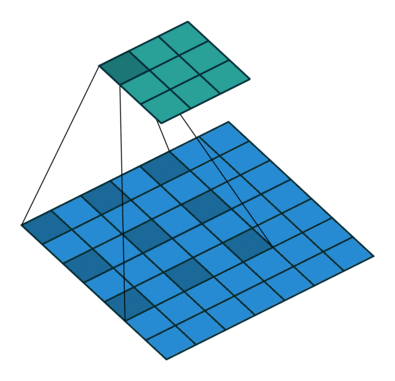

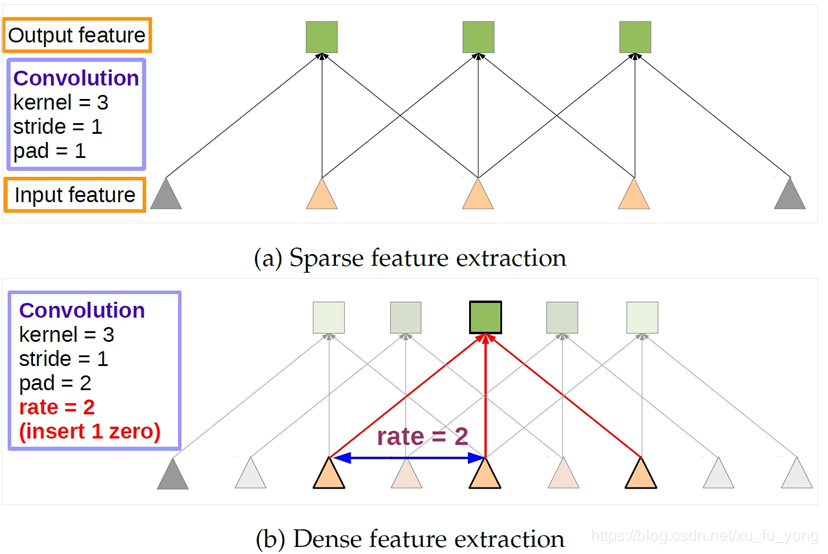

The above figure (b) is a convolution with holes. You can jump to choose and add one every other.
The third example (c) in the figure below is convolution with holes.

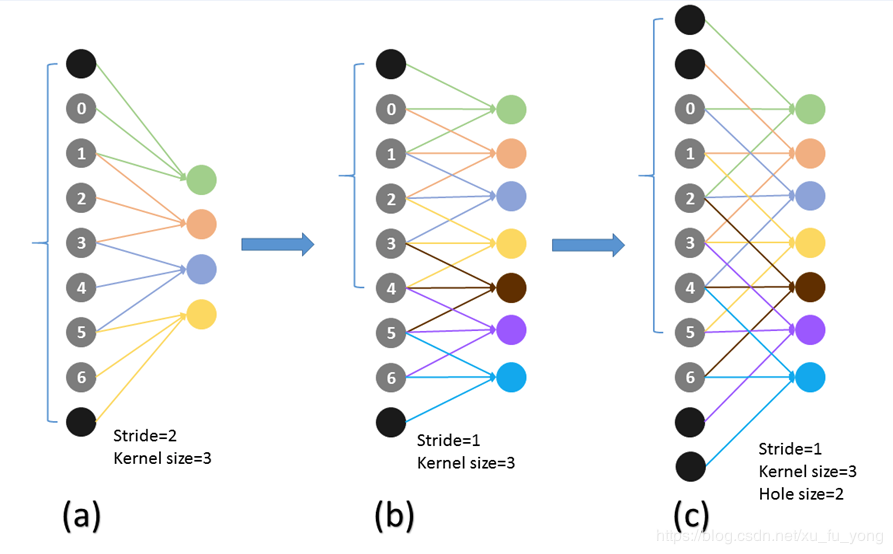

Convolution reduces the size of the kernel and can save memory.
And the effectiveness of convolution with holes is based on the assumption that closely adjacent pixels are almost the same, and all of them are redundant, so it is better to jump to H (hole size) and take one.

### Results

There are two Models: **SSD300** and **SSD512.**
**SSD300**: 300×300 input image, lower resolution, faster.
**SSD512**: 512×512 input image, higher resolution, more accurate.

Let’s see the results.

### Model Analysis

**PASCAL VOC 2007**

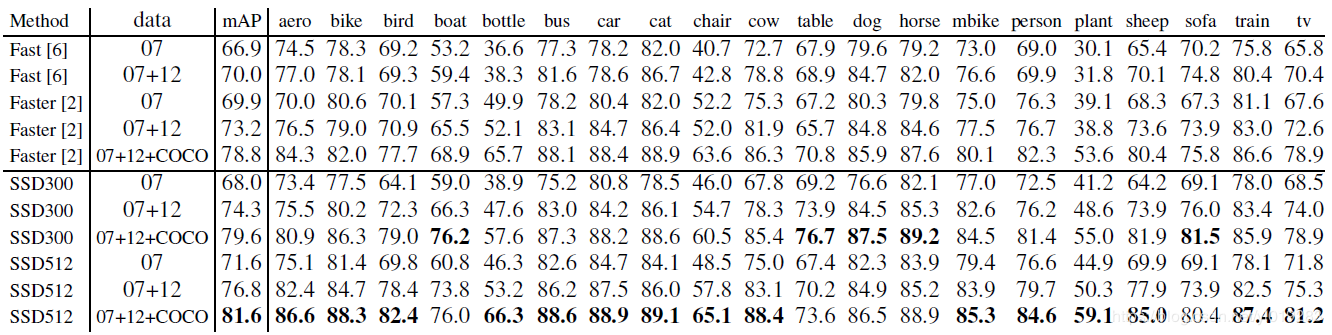

As shown above, SSD512 has 81.6% mAP. And SSD300 has 79.6% mAP which is already better than Faster R-CNN of 78.8%.

**PASCAL VOC 2012**

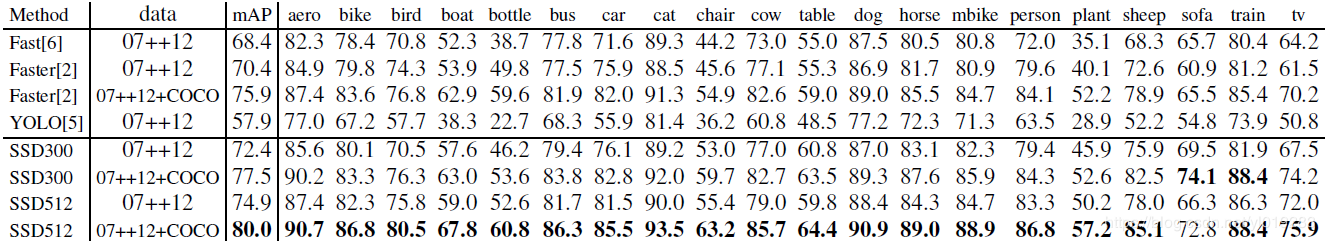

SSD512 (80.0%) is 4.1% more accurate than Faster R-CNN (75.9%).

**MS COCO**


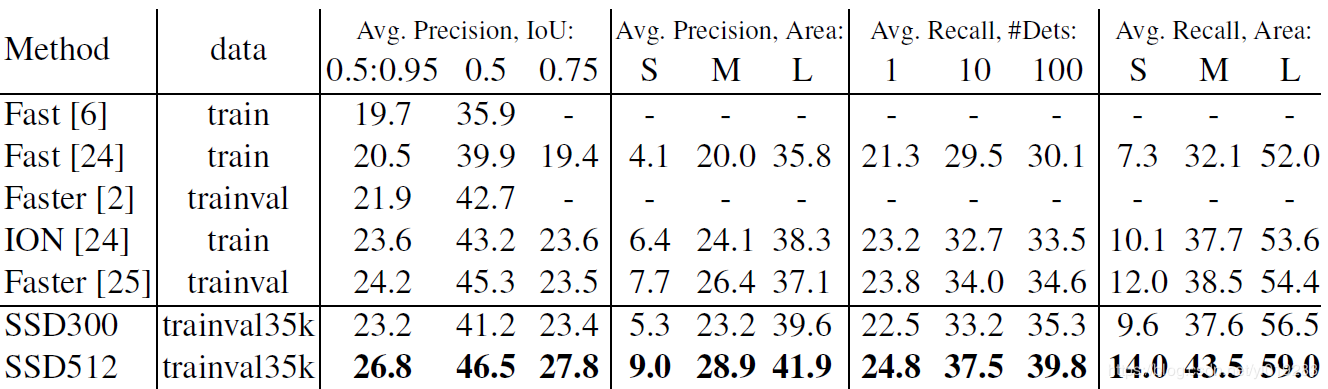

SSD512 is only 1.2% better than Faster R-CNN in mAP@0.5. This is because it has much better AP (4.8%) and AR (4.6%) for larger objects, but has relatively less improvement in AP (1.3%) and AR (2.0%) for small objects.

`**Faster R-CNN is more competitive on smaller objects with SSD. Authors believe it is due to the RPN-based approaches which consist of two shots.**`

### Data Augmentation for Small Object Accuracy

To overcome the weakness of missing detection on small object as mentioned in 6.4, “zoom out” operation is done to create more small training samples. And an increase of 2%-3% mAP is achieved across multiple datasets as shown below:

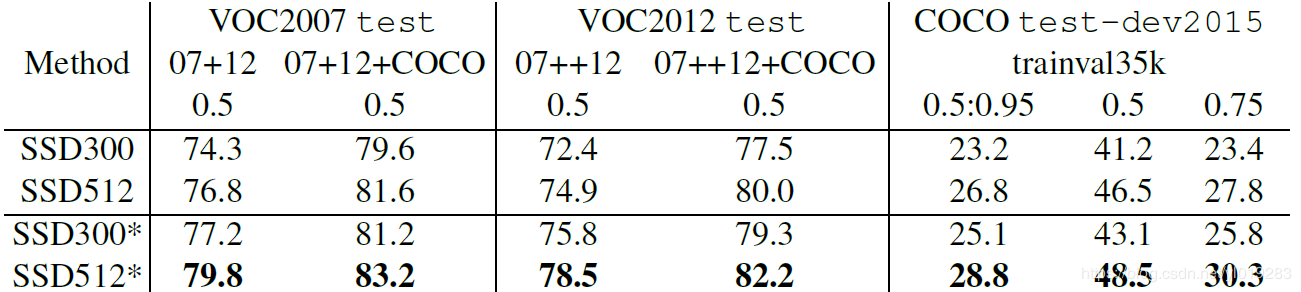

### Inference Time


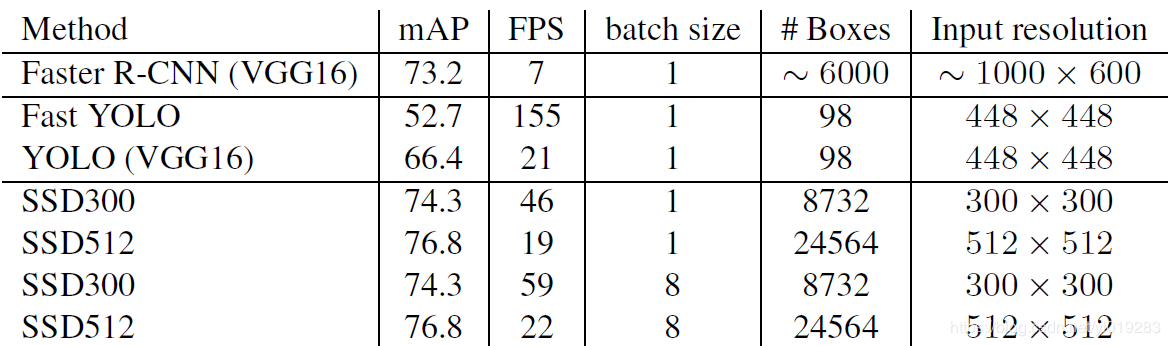

* With batch size of 1, SSD300 and SSD512 can obtain 46 and 19 FPS respectively.
* With batch size of 8, SSD300 and SSD512 can obtain 59 and 22 FPS respectively.




### Analysis of the advantages and disadvantages of SSD network structure

The advantages of the indented SSD algorithm should be obvious: the running speed is comparable to YOLO, and the detection accuracy is comparable to Faster RCNN. In addition, there are some trivial advantages that are not explained. Talk about the disadvantages here:

* We need to manually set the min_size, max_size, and aspect_ratio values ​​of the priority box. The basic size and shape of the priority box in the network cannot be directly obtained through learning, but need to be set manually. The size and shape of the priority boxes used by each layer of features in the network are exactly the same, resulting in the debugging process being very dependent on experience.

* Although the idea of ​​the pyramid feature hierarchy is adopted, the recall of small targets is still average and has not reached the level of crushing Faster RCNN. The author believes that this is because SSD uses conv4_3 low-level features to detect small targets, while the number of low-level feature convolutional layers is small, and there is a problem of insufficient feature extraction.
